In [1]:
# 1. データ読み込み・データ定義
from tkinter import filedialog
from tkinter import Tk
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from scipy.spatial import ConvexHull, Delaunay
import shap
import xgboost as xgb
import alphashape

root = Tk()
root.withdraw()

# 1. read data
csv_file_path = filedialog.askopenfilename(title="Select Test-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))

# 1-1. df define
df = pd.read_csv(csv_file_path)
df_setting = pd.read_excel(Setting_File_path)

feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

# 1-2. mode check @ test-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)


#1-3. data define
target_mode = "2wfF4"
train_df = df[df['Mode'] != target_mode]
test_df = df[df['Mode'] == target_mode]

train_data = train_df[feature_vars]
test_data = test_df[feature_vars]
target_data = train_df[target_variable]

# Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']

Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']


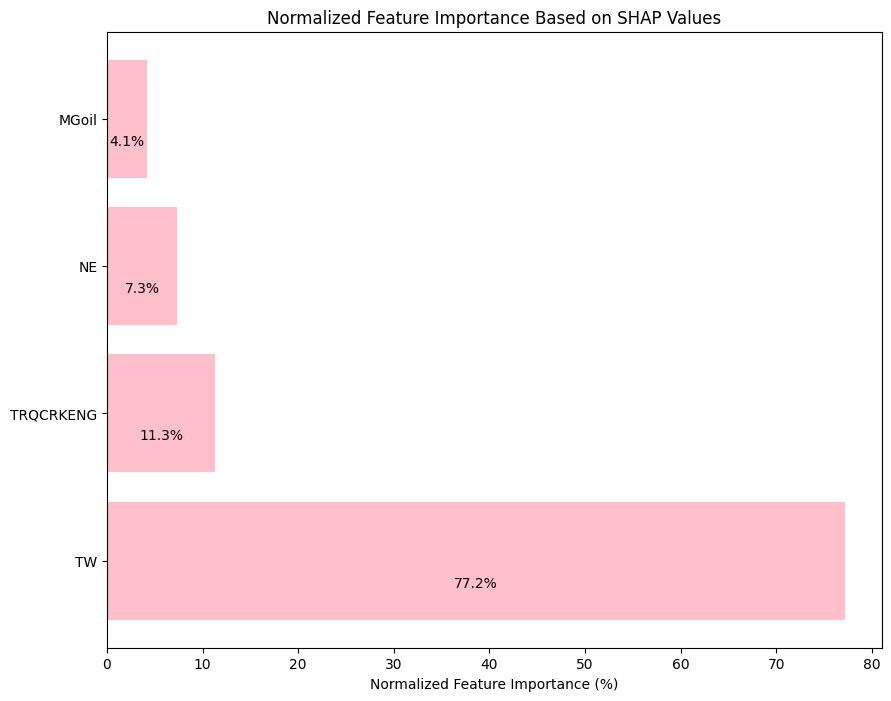

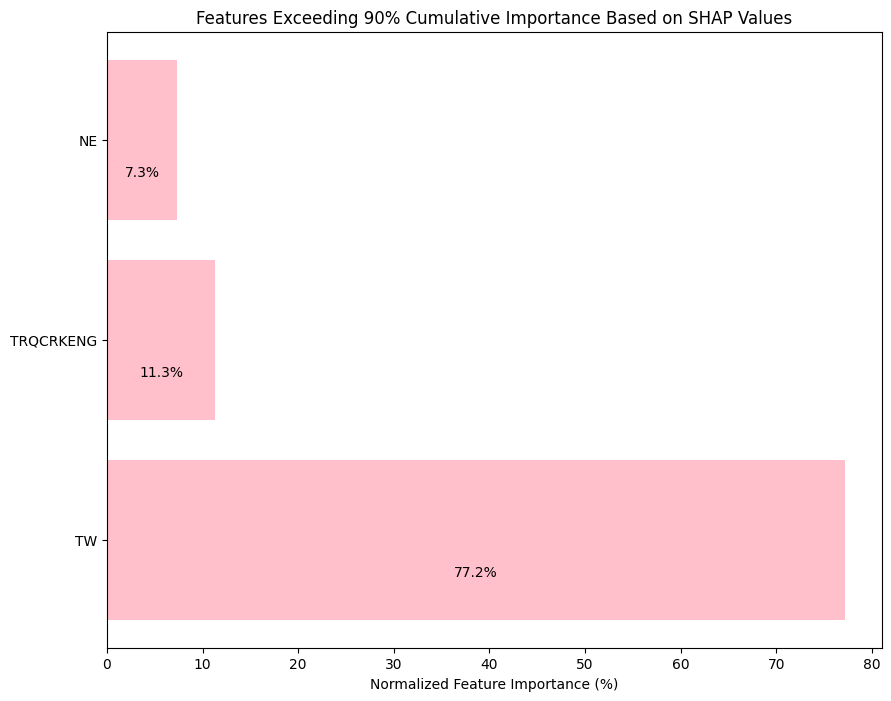

In [2]:
# Train XGBoost model to compute SHAP values
model = xgb.XGBRegressor(n_jobs=-1) # n_jobs=-1で利用できる全CPUコアを使う
model.fit(train_data, target_data) 

# Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(train_data)

# Get feature importances and sort them
feature_importance = np.abs(shap_values.values).mean(axis=0)
sorted_idx = np.argsort(-feature_importance) 
sorted_importance = feature_importance[sorted_idx]

# Normalize feature_importance to sum up to 100%
normalized_importance = (sorted_importance / np.sum(sorted_importance)) * 100

# Visualization 1: Plotting each feature's normalized SHAP importance with percentage labels, sorted by importance
plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(sorted_idx)), normalized_importance, align='center', color='pink')  # Changed bar color to pink
plt.yticks(range(len(sorted_idx)), [feature_vars[i] for i in sorted_idx])  # Now sorted in descending order
plt.xlabel('Normalized Feature Importance (%)')
plt.title('Normalized Feature Importance Based on SHAP Values')

# Add percentage labels on the bars, rounded to 1 decimal place, and aligned to the middle of the bar
for bar in bars:
    plt.gca().text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/4,
                   f"{bar.get_width():.1f}%", color="black", fontsize=10, ha='center', va='bottom')  # Changed text color to black

plt.show()

# Select features with cumulative importance > 0.9
cumulative_importance = np.cumsum(sorted_importance / np.sum(sorted_importance))
selected_features_idx = np.where(cumulative_importance > 0.9)[0][0]  # Get the index where cumulative importance exceeds 90%
selected_features = [feature_vars[sorted_idx[i]] for i in range(selected_features_idx + 1)]  # Include the feature that made it exceed 90%
selected_normalized_importance = normalized_importance[:selected_features_idx + 1]

# Visualization 2: Plotting the selected features that exceed 90% of cumulative importance
plt.figure(figsize=(10, 8))
bars = plt.barh(range(len(selected_features)), selected_normalized_importance, align='center', color='pink')  # Changed bar color to pink
plt.yticks(range(len(selected_features)), [feature_vars[sorted_idx[i]] for i in range(selected_features_idx + 1)])
plt.xlabel('Normalized Feature Importance (%)')
plt.title('Features Exceeding 90% Cumulative Importance Based on SHAP Values')

# Add percentage labels on the bars, rounded to 1 decimal place, and aligned to the middle of the bar
for bar in bars:
    plt.gca().text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/4,
                   f"{bar.get_width():.1f}%", color="black", fontsize=10, ha='center', va='bottom')  # Changed text color to black

plt.show()


PCA Components (Feature Weights):
           TW  TRQCRKENG        NE
PC1  0.269129   0.677131  0.684882
PC2 -0.962082   0.221772  0.158795


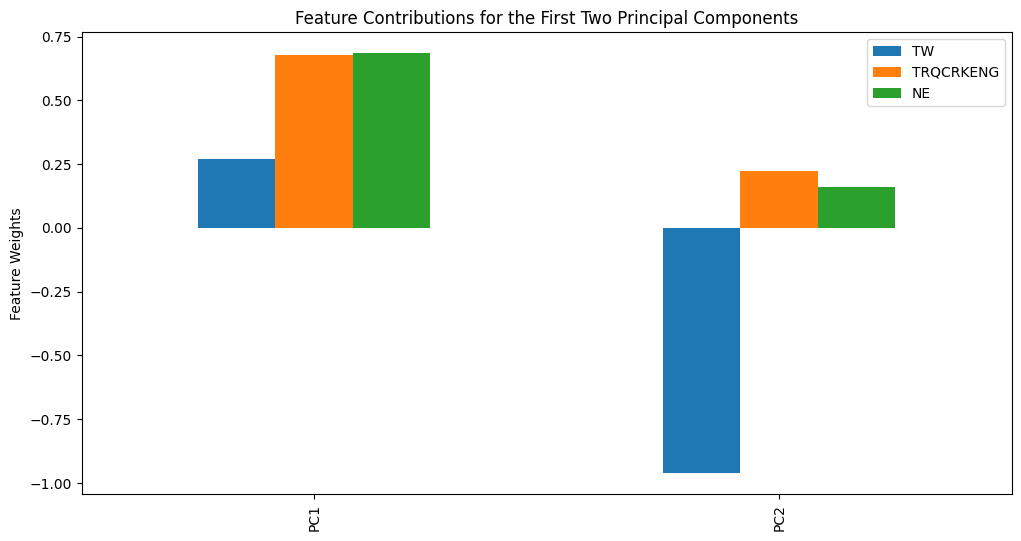

In [3]:
scaler = StandardScaler()
selected_train_data = scaler.fit_transform(train_data[selected_features])
selected_test_data = scaler.transform(test_data[selected_features])

# PCA
pca = PCA(n_components=0.9)
pca_train_data = pca.fit_transform(selected_train_data)
pca_test_data = pca.transform(selected_test_data)

# Visualize PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
plt.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data') 
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Calculate the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio1 = explained_variance_ratio[0] * 100
explained_variance_ratio2 = explained_variance_ratio[1] * 100

# Add the explained variance ratio to the plot title
plt.title(f'PC1 {explained_variance_ratio1:.2f}%, PC2 {explained_variance_ratio2:.2f}%')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Investigating the feature contributions for each principal component
components_df = pd.DataFrame(pca.components_, columns=selected_features, index=[f'PC{i+1}' for i in range(len(pca.components_))])

# Display the components in the console
print("PCA Components (Feature Weights):")
print(components_df)

# Visualize the feature contributions for the first two principal components
components_df.iloc[:2, :].plot(kind='bar', figsize=(12, 6))
plt.title('Feature Contributions for the First Two Principal Components')
plt.ylabel('Feature Weights')
plt.show()


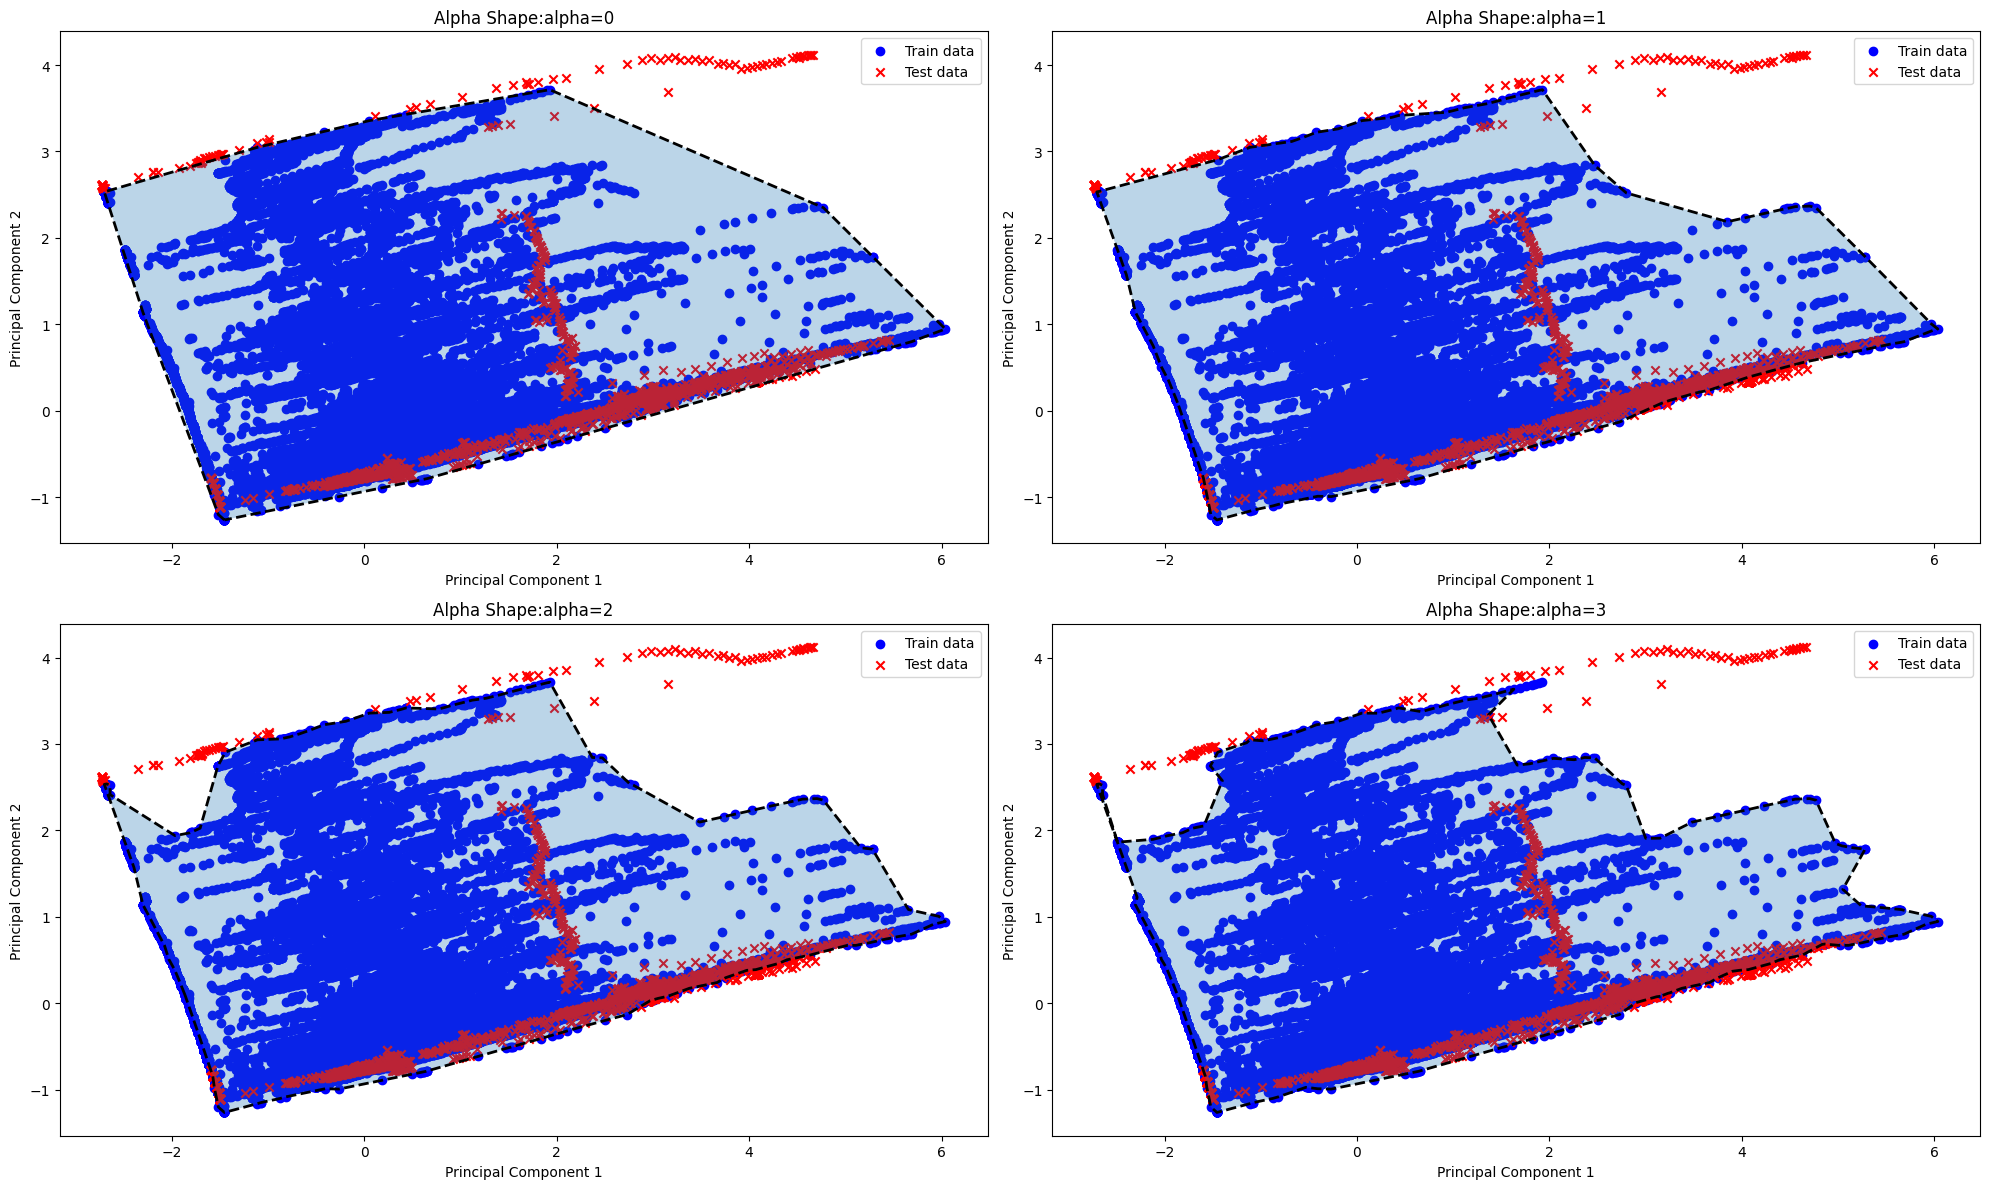

In [4]:
from shapely.geometry import MultiPoint, Polygon, Point
from alphashape import alphashape #alphashapeモジュールからalphashape関数をインポート

# Initialize dictionaries to store the results for each alpha_value
outsider_test_points = {}
boundary_train_points = {}

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

for i, alpha_value in enumerate(range(0, 4)):
    ax = axes[i//2, i%2]
    alpha_shape = alphashape(pca_train_data, alpha=alpha_value)
    
    # Identify the test points that are outside the alpha_shape
    outsider_test_indices = []
    for i, point in enumerate(pca_test_data):
        shapely_point = Point(point)
        if not alpha_shape.contains(shapely_point):
            outsider_test_indices.append(i)
    outsider_test_points[alpha_value] = pca_test_data[outsider_test_indices]
    
    # Identify the train points that form the boundary of the alpha_shape
    if alpha_shape.geom_type == 'Polygon':
        boundary_shape = Polygon(alpha_shape.exterior.coords)
    elif alpha_shape.geom_type == 'MultiPolygon':
        boundary_shape = MultiPoint([shape.exterior.coords for shape in alpha_shape])
    
    boundary_train_indices = []
    for i, point in enumerate(pca_train_data):
        if Point(point).within(boundary_shape.buffer(1e-5)):  # buffer to handle floating point inaccuracies
            boundary_train_indices.append(i)
    boundary_train_points[alpha_value] = pca_train_data[boundary_train_indices]
    
    ax.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
    ax.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data')
    
    if alpha_shape.geom_type == 'Polygon':
        ax.plot(*alpha_shape.exterior.xy, c='k', linestyle='--', lw=2)
        ax.fill(*alpha_shape.exterior.xy, alpha=0.3)
    elif alpha_shape.geom_type == 'MultiPolygon':
        for shape in alpha_shape:
            ax.plot(*shape.exterior.xy, c='k', linestyle='--', lw=2)
            ax.fill(*shape.exterior.xy, alpha=0.3)
    
    ax.set_title(f'Alpha Shape:alpha={alpha_value}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend()

plt.tight_layout()
plt.show()


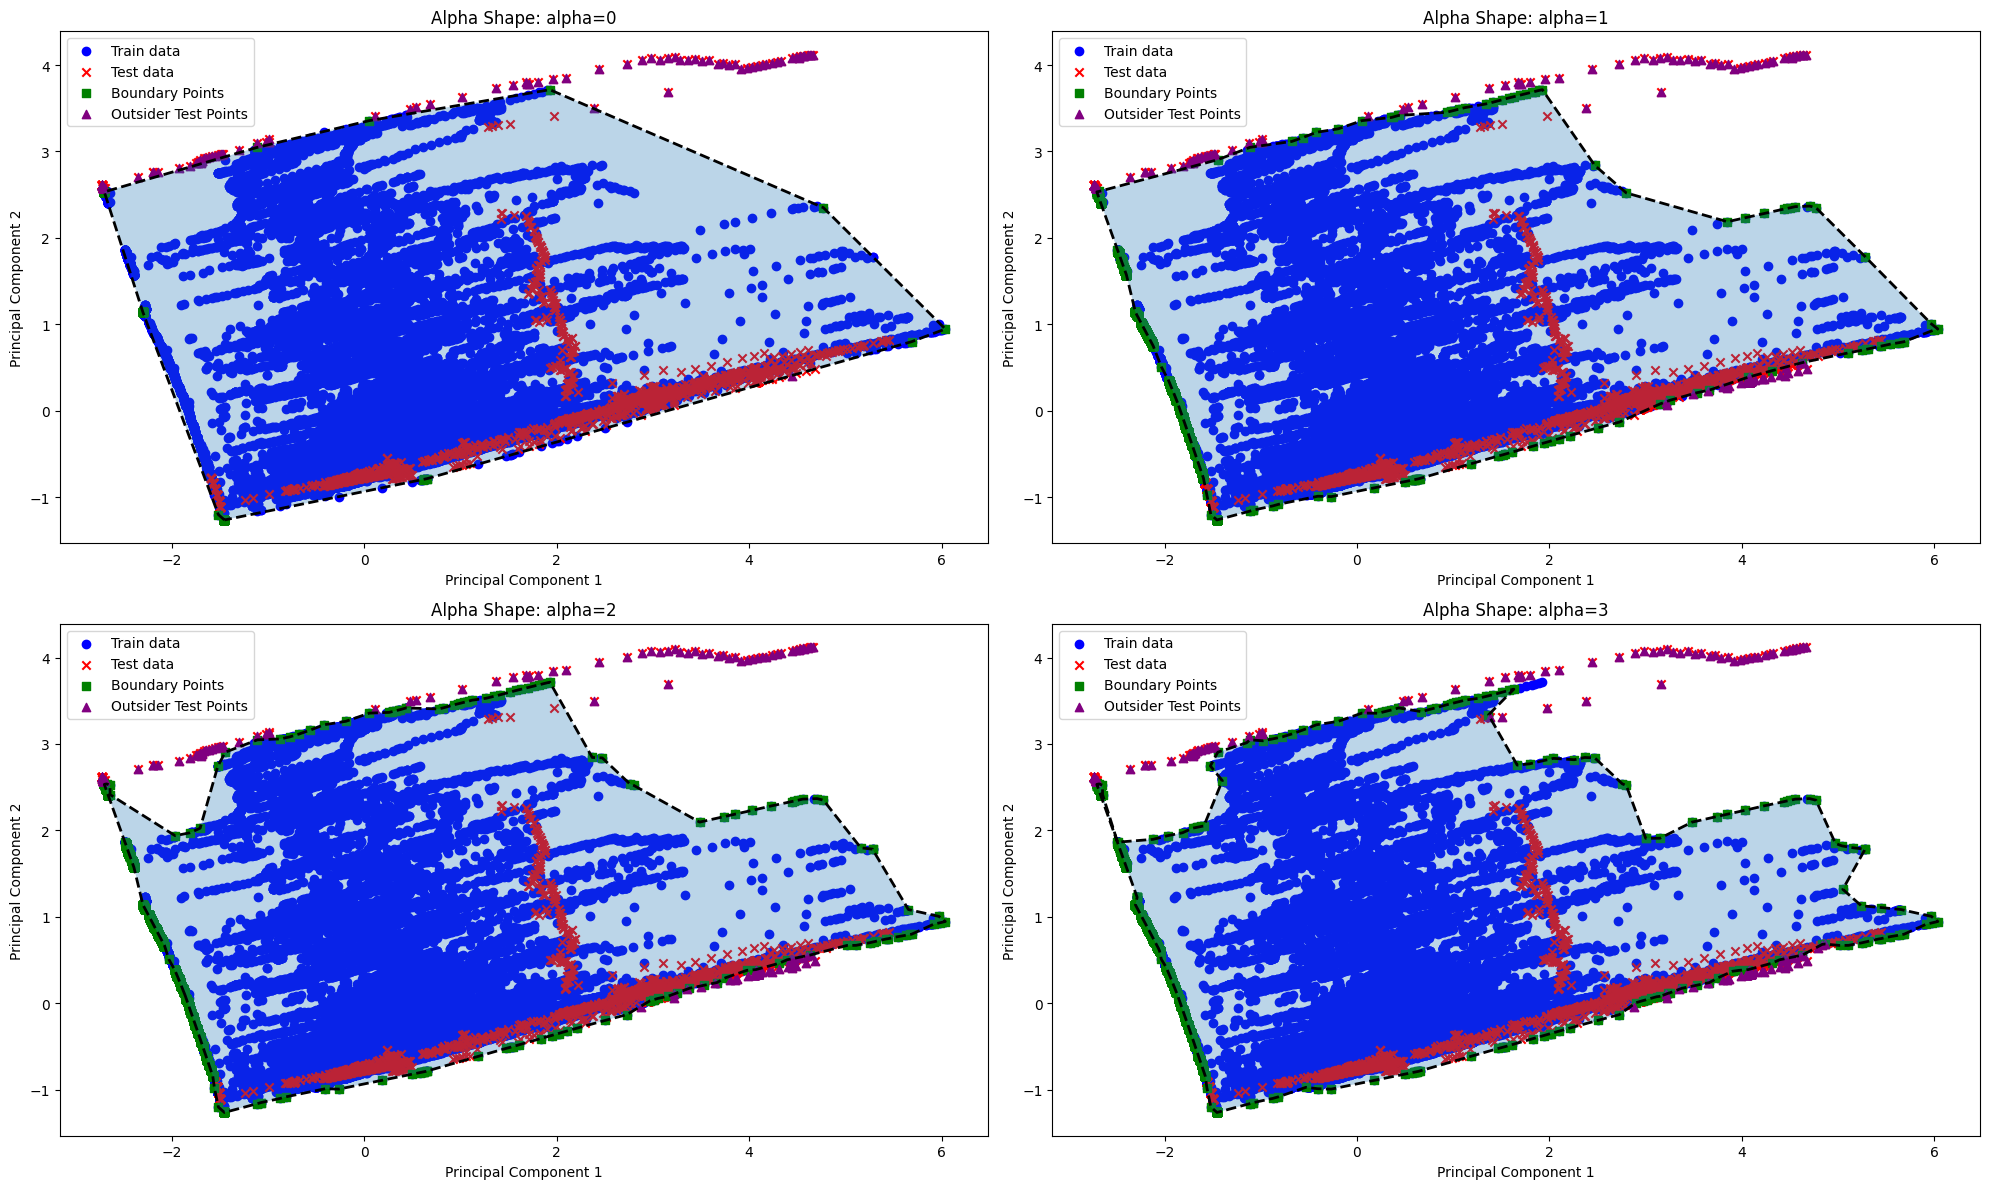

In [5]:
from shapely.geometry import MultiPoint, Point, shape
from alphashape import alphashape
from rtree import index
import numpy as np
import matplotlib.pyplot as plt

# Check if a point is near the boundary of the alpha shape
def is_near_boundary(point, alpha_shape, threshold=1e-5):
    point = Point(point)
    return alpha_shape.boundary.distance(point) < threshold

# Initialize dictionaries to store the results for different alpha values
outsider_test_points = {}
boundary_train_points = {}

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

for i, alpha_value in enumerate(range(0, 4)):
    ax = axes[i//2, i%2]
    alpha_shape = alphashape(pca_train_data, alpha=alpha_value)
    
    # Identify the test points that are outside the alpha shape
    outsider_test_indices = [not alpha_shape.contains(Point(point)) for point in pca_test_data]
    outsider_test_points[alpha_value] = pca_test_data[np.where(outsider_test_indices)]
    
    # Identify the train points that form the boundary of the alpha shape
    boundary_train_indices = [is_near_boundary(point, alpha_shape) for point in pca_train_data]
    boundary_train_points[alpha_value] = pca_train_data[np.where(boundary_train_indices)]
    
    # Plotting
    ax.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
    ax.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data')
    ax.scatter(boundary_train_points[alpha_value][:, 0], boundary_train_points[alpha_value][:, 1], c='green', marker='s', label='Boundary Points')
    ax.scatter(outsider_test_points[alpha_value][:, 0], outsider_test_points[alpha_value][:, 1], c='purple', marker='^', label='Outsider Test Points')

    if alpha_shape.geom_type == 'Polygon':
        ax.plot(*alpha_shape.exterior.xy, c='k', linestyle='--', lw=2)
        ax.fill(*alpha_shape.exterior.xy, alpha=0.3)
    elif alpha_shape.geom_type == 'MultiPolygon':
        for shape in alpha_shape:
            ax.plot(*shape.exterior.xy, c='k', linestyle='--', lw=2)
            ax.fill(*shape.exterior.xy, alpha=0.3)

    ax.set_title(f'Alpha Shape: alpha={alpha_value}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend()

plt.tight_layout()
plt.show()


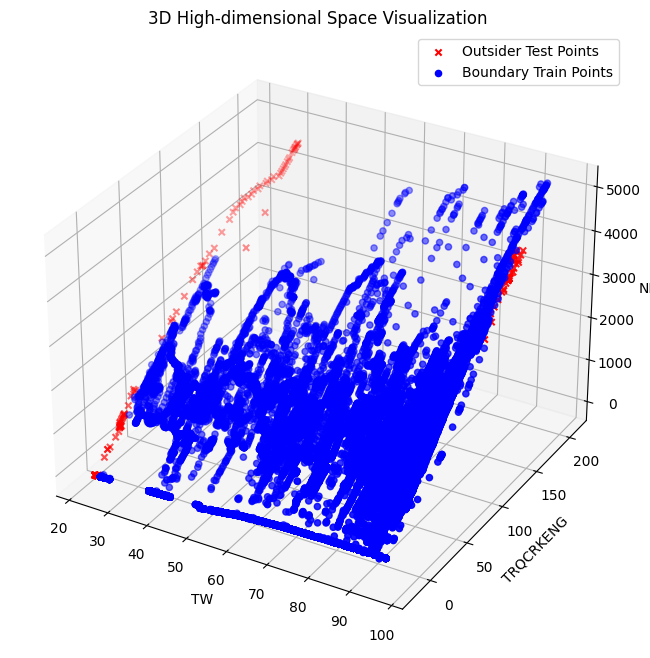

In [35]:
#choose alpha_value of alpha shape
alpha_mode=2
selected_outsider_test_points = outsider_test_points[alpha_mode]
selected_boundary_train_points = boundary_train_points[alpha_mode]

# Inverse transform to original space
# For test points
inv_pca_outsider_test = pca.inverse_transform(selected_outsider_test_points) #PCAの逆変換
inv_scaler_outsider_test = scaler.inverse_transform(inv_pca_outsider_test) #標準化の逆変換=原始変数の状態に復元

# For train boundary points
inv_pca_boundary_train = pca.inverse_transform(selected_boundary_train_points)
inv_scaler_boundary_train = scaler.inverse_transform(inv_pca_boundary_train)

# Extract original feature names
feature_names = selected_features

# 3D Visualizing in high-dimensional space
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the inverse transformed test data points
ax.scatter(inv_scaler_outsider_test[:, 0], inv_scaler_outsider_test[:, 1], inv_scaler_outsider_test[:, 2], c='red', marker='x', label='Outsider Test Points')

# Plotting the inverse transformed train boundary points
ax.scatter(inv_scaler_boundary_train[:, 0], inv_scaler_boundary_train[:, 1], inv_scaler_boundary_train[:, 2], c='blue', marker='o', label='Boundary Train Points')

ax.set_title('3D High-dimensional Space Visualization')
ax.set_xlabel(feature_names[0])  
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])
ax.legend()
plt.show()

# Export to HTML
df_outsider_test = pd.DataFrame(inv_scaler_outsider_test, columns=feature_names)
df_outsider_test['label'] = 'Outsider Test Points'

df_boundary_train = pd.DataFrame(inv_scaler_boundary_train, columns=feature_names)
df_boundary_train['label'] = 'Boundary Train Points'

# データフレーム結合
df_combined = pd.concat([df_outsider_test, df_boundary_train])

# 3D 散布図をプロット
fig = px.scatter_3d(df_combined, x=feature_names[0], y=feature_names[1], z=feature_names[2], color='label')
fig.write_html("invPCA_3D_Plot.html")


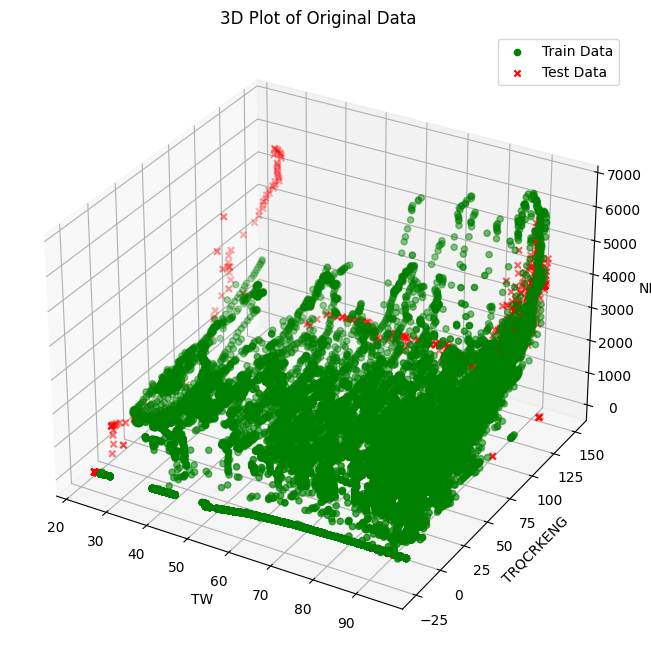

In [36]:
# train_data[selected_features]は原始変数(標準化はされてない)

# 3D Visualization in original high-dimensional space
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting all the original train data points
ax.scatter(train_data[selected_features].iloc[:, 0], train_data[selected_features].iloc[:, 1], train_data[selected_features].iloc[:, 2], c='green', marker='o', label='Train Data')

# Plotting all the original test data points
ax.scatter(test_data[selected_features].iloc[:, 0], test_data[selected_features].iloc[:, 1], test_data[selected_features].iloc[:, 2], c='red', marker='x', label='Test Data')

# Axis labels and title
ax.set_xlabel(selected_features[0])
ax.set_ylabel(selected_features[1])
ax.set_zlabel(selected_features[2])
ax.set_title('3D Plot of Original Data')
ax.legend()
plt.show()


# 元の訓練データとテストデータをデータフレームに変換
df_train_data = train_data[selected_features]
df_train_data['label'] = 'Train Data'

df_test_data = test_data[selected_features]
df_test_data['label'] = 'Test Data'

# データフレーム結合
df_combined = pd.concat([df_train_data, df_test_data])

# 3D export
fig = px.scatter_3d(df_combined, x=selected_features[0], y=selected_features[1], z=selected_features[2], color='label')
fig.write_html("Original_3D_Plot.html")


In [38]:
import plotly.graph_objects as go

# Calculating Convex Hull for the original train data
points = train_data[selected_features].to_numpy()
hull = ConvexHull(points)

# Create a Plotly figure
fig = go.Figure()

# Add scatter plot for original train data
fig.add_trace(go.Scatter3d(x=train_data[selected_features].iloc[:, 0],
                           y=train_data[selected_features].iloc[:, 1],
                           z=train_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='green'),
                           name='Train Data'))

# Add scatter plot for original test data
fig.add_trace(go.Scatter3d(x=test_data[selected_features].iloc[:, 0],
                           y=test_data[selected_features].iloc[:, 1],
                           z=test_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Test Data'))

# Add mesh for Convex Hull
fig.add_trace(go.Mesh3d(x=points[:, 0],
                         y=points[:, 1],
                         z=points[:, 2],
                         i=hull.simplices[:, 0],
                         j=hull.simplices[:, 1],
                         k=hull.simplices[:, 2],
                         opacity=0.5,
                         name='Convex Hull'))

# Set axis labels
fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                             yaxis_title=selected_features[1],
                             zaxis_title=selected_features[2]),
                  title='3D Plot of Original Data with Convex Hull')

# Save as HTML
fig.write_html("Original_3D_Plot_with_Convex_Hull.html")

# Show the plot
fig.show()


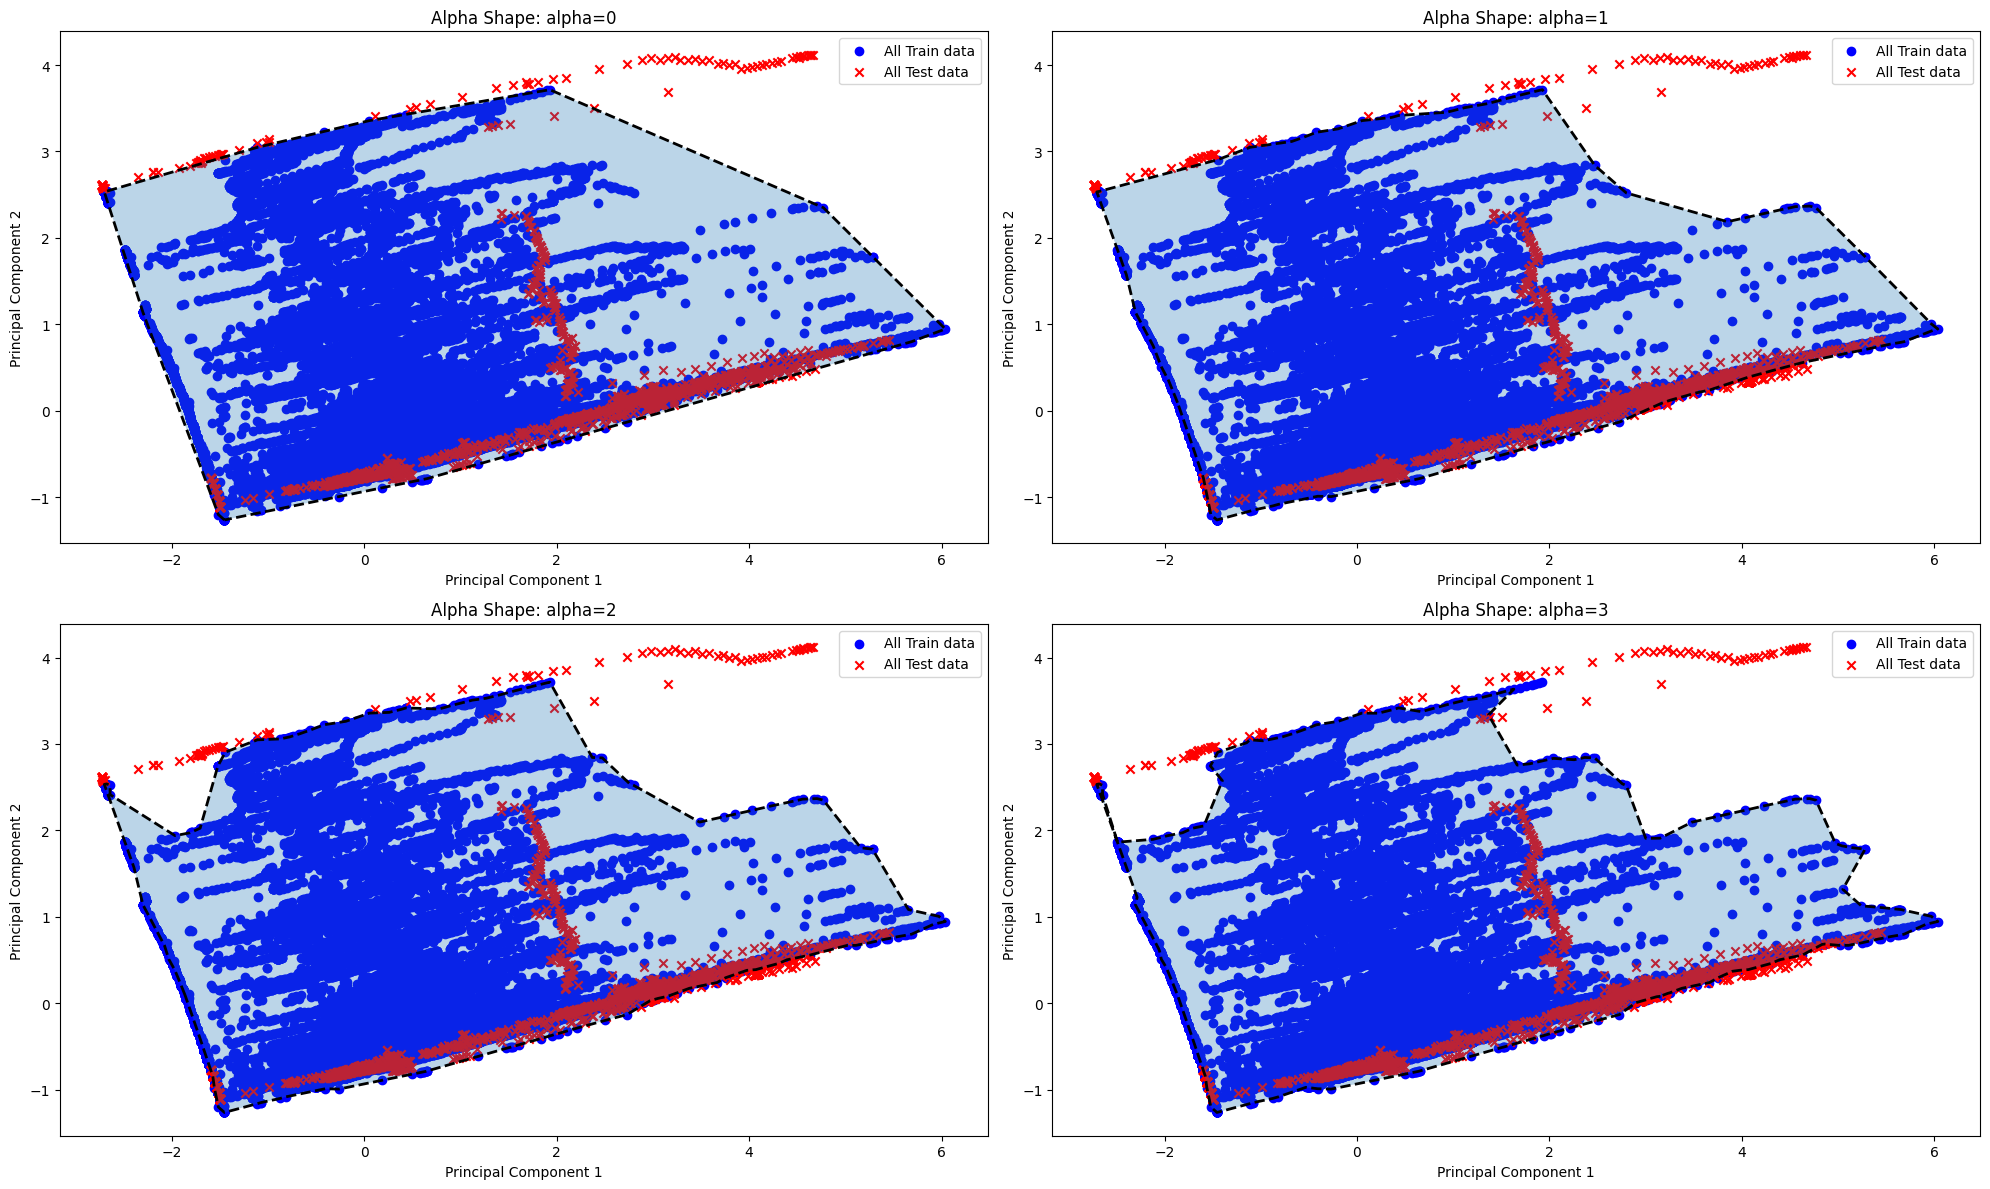

In [39]:
from shapely.geometry import MultiPoint, Polygon

# Initialize dictionaries to store the results for each alpha_value
outsider_test_points = {}
boundary_train_points = {}
all_train_points = {}
all_test_points = {}

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

for i, alpha_value in enumerate(range(0, 4)):
    ax = axes[i//2, i%2]
    alpha_shape = alphashape(pca_train_data, alpha=alpha_value)
    
    # Store all train points for each alpha_value
    all_train_points[alpha_value] = pca_train_data
    
    # Store all test points for each alpha_value
    all_test_points[alpha_value] = pca_test_data
    
    # Identify the test points that are outside the alpha_shape
    outsider_test_indices = []
    for i, point in enumerate(pca_test_data):
        shapely_point = Point(point)
        if not alpha_shape.contains(shapely_point):
            outsider_test_indices.append(i)
    outsider_test_points[alpha_value] = pca_test_data[outsider_test_indices]
    
    # Identify the train points that form the boundary of the alpha_shape
    if alpha_shape.geom_type == 'Polygon':
        boundary_shape = Polygon(alpha_shape.exterior.coords)
    elif alpha_shape.geom_type == 'MultiPolygon':
        boundary_shape = MultiPoint([shape.exterior.coords for shape in alpha_shape])
    
    boundary_train_indices = []
    for i, point in enumerate(pca_train_data):
        if Point(point).within(boundary_shape.buffer(1e-5)):  # buffer to handle floating point inaccuracies
            boundary_train_indices.append(i)
    boundary_train_points[alpha_value] = pca_train_data[boundary_train_indices]
    
    # Plot all train and test data
    ax.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='All Train data')
    ax.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='All Test data')
    
    # Plot alpha_shape
    if alpha_shape.geom_type == 'Polygon':
        ax.plot(*alpha_shape.exterior.xy, c='k', linestyle='--', lw=2)
        ax.fill(*alpha_shape.exterior.xy, alpha=0.3)
    elif alpha_shape.geom_type == 'MultiPolygon':
        for shape in alpha_shape:
            ax.plot(*shape.exterior.xy, c='k', linestyle='--', lw=2)
            ax.fill(*shape.exterior.xy, alpha=0.3)
    
    ax.set_title(f'Alpha Shape: alpha={alpha_value}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend()

plt.tight_layout()
plt.show()


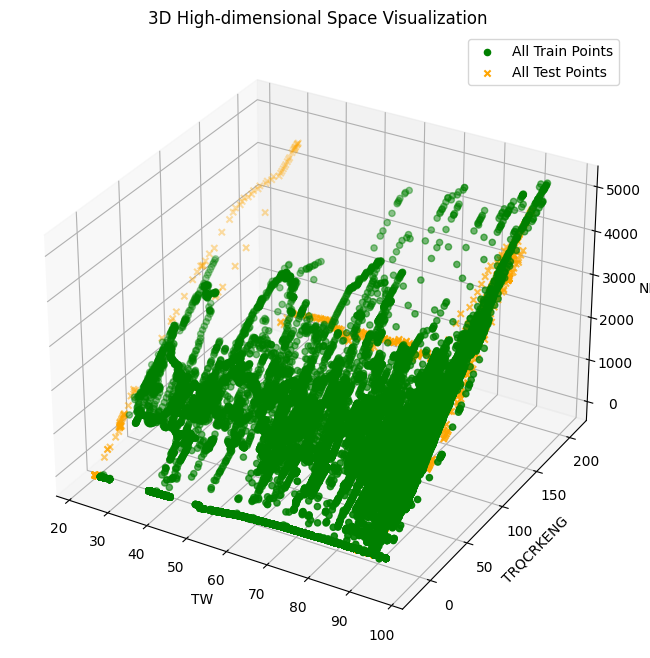

In [40]:
# choose alpha_value of alpha shape
alpha_mode = 2
selected_all_train_points = all_train_points[alpha_mode]
selected_all_test_points = all_test_points[alpha_mode]

# Inverse transform to original space
# For all train and test points
inv_pca_all_train = pca.inverse_transform(selected_all_train_points)
inv_scaler_all_train = scaler.inverse_transform(inv_pca_all_train)

inv_pca_all_test = pca.inverse_transform(selected_all_test_points)
inv_scaler_all_test = scaler.inverse_transform(inv_pca_all_test)

# Extract original feature names
feature_names = selected_features

# 3D Visualizing in high-dimensional space
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the inverse transformed all train data points
ax.scatter(inv_scaler_all_train[:, 0], inv_scaler_all_train[:, 1], inv_scaler_all_train[:, 2], c='green', marker='o', label='All Train Points')

# Plotting the inverse transformed all test data points
ax.scatter(inv_scaler_all_test[:, 0], inv_scaler_all_test[:, 1], inv_scaler_all_test[:, 2], c='orange', marker='x', label='All Test Points')

ax.set_title('3D High-dimensional Space Visualization')
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[1])
ax.set_zlabel(feature_names[2])
ax.legend()
plt.show()

# Export to HTML
df_all_train = pd.DataFrame(inv_scaler_all_train, columns=feature_names)
df_all_train['label'] = 'All Train Points'

df_all_test = pd.DataFrame(inv_scaler_all_test, columns=feature_names)
df_all_test['label'] = 'All Test Points'

# データフレーム結合
df_combined = pd.concat([df_all_train, df_all_test])

# 3D 散布図をプロット
fig = px.scatter_3d(df_combined, x=feature_names[0], y=feature_names[1], z=feature_names[2], color='label')
fig.write_html("invPCA_All_Points_3D_Plot.html")


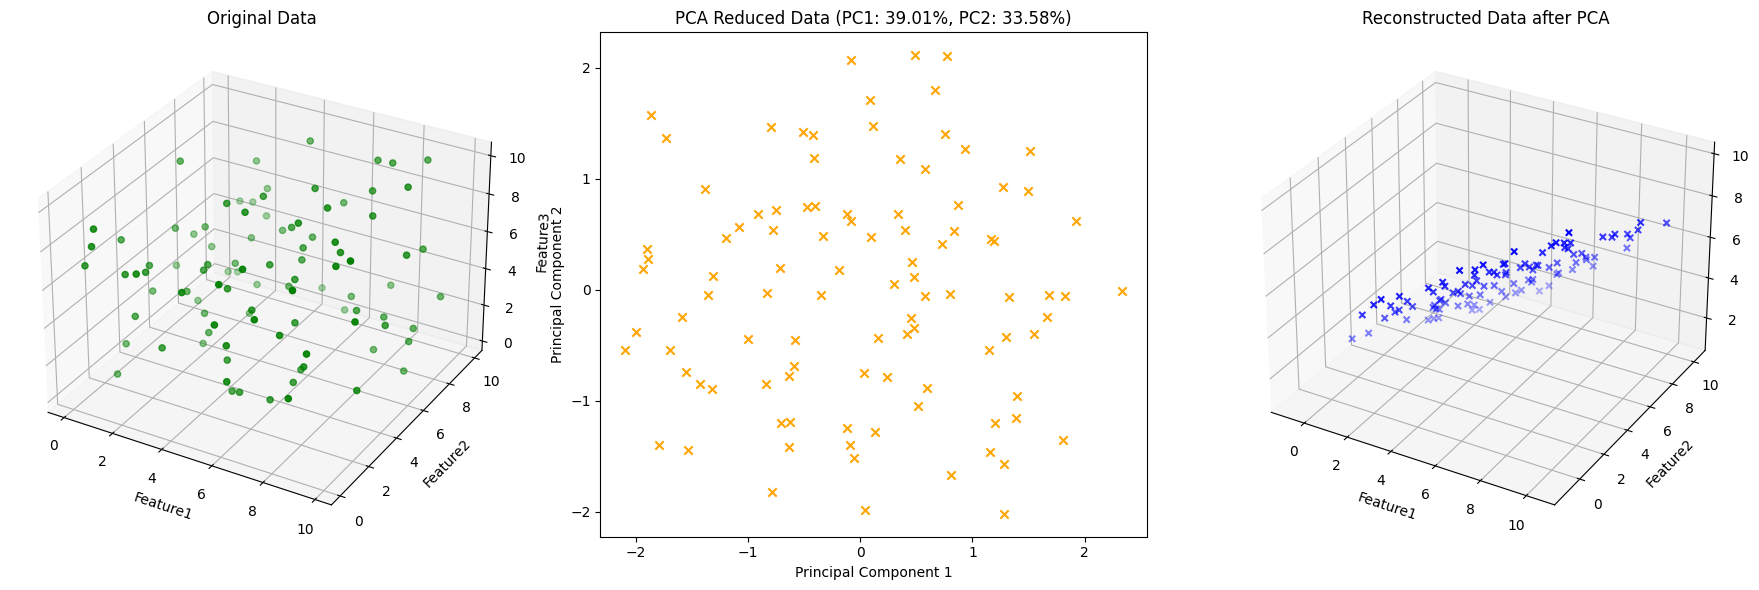

In [81]:
# 必要なライブラリをインポート
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# これをtrain_data[selected_features]で置き換えてください
# デモンストレーションのため、ランダムなデータを生成しています
np.random.seed(0)
train_data = pd.DataFrame(np.random.rand(100, 3) * 10, columns=['Feature1', 'Feature2', 'Feature3'])
selected_features = ['Feature1', 'Feature2', 'Feature3']

# 標準化
scaler = StandardScaler()
selected_train_data = scaler.fit_transform(train_data[selected_features])

# PCA変換
pca = PCA(n_components=2)
pca_train_data = pca.fit_transform(selected_train_data)

# 分散寄与
explained_var_ratio = pca.explained_variance_ratio_ * 100
explained_var_str = ', '.join([f'PC{i+1}: {ratio:.2f}%' for i, ratio in enumerate(explained_var_ratio)])

# PCAデータを逆変換し、その後逆スケーリング
inv_pca_train_data = pca.inverse_transform(pca_train_data)
inv_scaled_train_data_after_pca = scaler.inverse_transform(inv_pca_train_data)

# Plotting
fig = plt.figure(figsize=(18, 6))

# 元のデータの3D可視化
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(train_data['Feature1'], train_data['Feature2'], train_data['Feature3'], c='green', marker='o')
ax1.set_title('Original Data')
ax1.set_xlabel('Feature1')
ax1.set_ylabel('Feature2')
ax1.set_zlabel('Feature3')

# PCA次元削減後の2D可視化
ax2 = fig.add_subplot(132)
ax2.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='orange', marker='x')
ax2.set_title(f'PCA Reduced Data ({explained_var_str})')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')

# PCAと逆変換後の3D可視化
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(inv_scaled_train_data_after_pca[:, 0], inv_scaled_train_data_after_pca[:, 1], inv_scaled_train_data_after_pca[:, 2], c='blue', marker='x')
ax3.set_title('Reconstructed Data after PCA')
ax3.set_xlabel('Feature1')
ax3.set_ylabel('Feature2')
ax3.set_zlabel('Feature3')

plt.tight_layout()
plt.show()


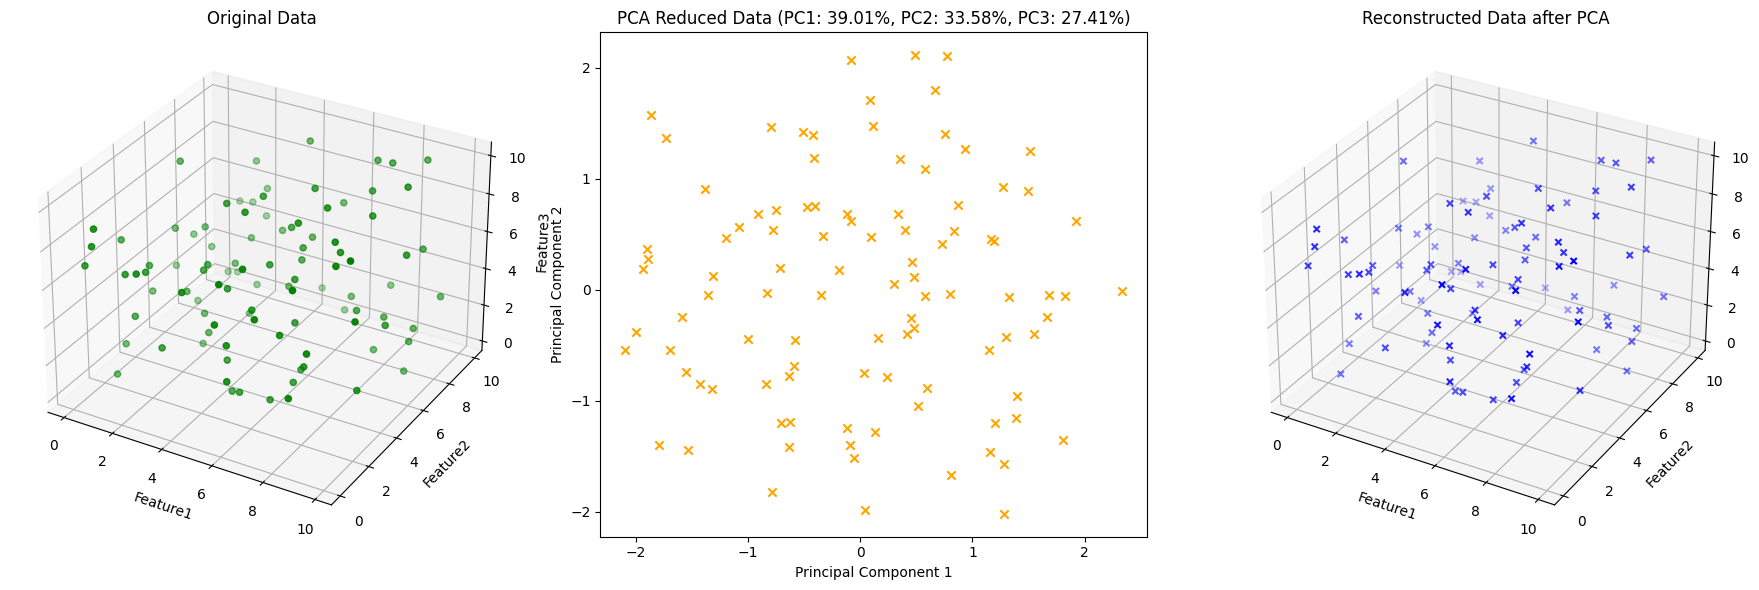

In [83]:
# 必要なライブラリをインポート
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# これをtrain_data[selected_features]で置き換えてください
# デモンストレーションのため、ランダムなデータを生成しています
np.random.seed(0)
train_data = pd.DataFrame(np.random.rand(100, 3) * 10, columns=['Feature1', 'Feature2', 'Feature3'])
selected_features = ['Feature1', 'Feature2', 'Feature3']

# 標準化
scaler = StandardScaler()
selected_train_data = scaler.fit_transform(train_data[selected_features])

# PCA変換
pca = PCA(n_components=0.9) #n_components=3 でも同じ結果
pca_train_data = pca.fit_transform(selected_train_data)

# 分散寄与
explained_var_ratio = pca.explained_variance_ratio_ * 100
explained_var_str = ', '.join([f'PC{i+1}: {ratio:.2f}%' for i, ratio in enumerate(explained_var_ratio)])

# PCAデータを逆変換し、その後逆スケーリング
inv_pca_train_data = pca.inverse_transform(pca_train_data)
inv_scaled_train_data_after_pca = scaler.inverse_transform(inv_pca_train_data)

# Plotting
fig = plt.figure(figsize=(18, 6))

# 元のデータの3D可視化
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(train_data['Feature1'], train_data['Feature2'], train_data['Feature3'], c='green', marker='o')
ax1.set_title('Original Data')
ax1.set_xlabel('Feature1')
ax1.set_ylabel('Feature2')
ax1.set_zlabel('Feature3')

# PCA次元削減後の2D可視化
ax2 = fig.add_subplot(132)
ax2.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='orange', marker='x')
ax2.set_title(f'PCA Reduced Data ({explained_var_str})')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')

# PCAと逆変換後の3D可視化
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(inv_scaled_train_data_after_pca[:, 0], inv_scaled_train_data_after_pca[:, 1], inv_scaled_train_data_after_pca[:, 2], c='blue', marker='x')
ax3.set_title('Reconstructed Data after PCA')
ax3.set_xlabel('Feature1')
ax3.set_ylabel('Feature2')
ax3.set_zlabel('Feature3')

plt.tight_layout()
plt.show()


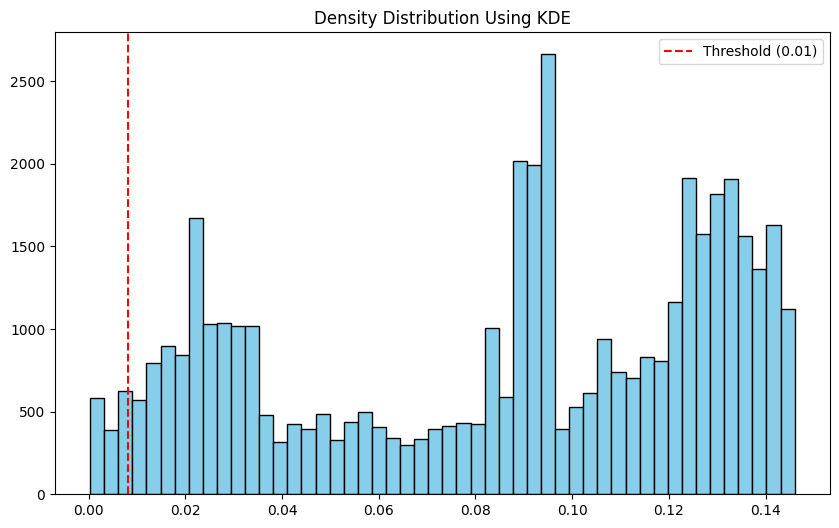

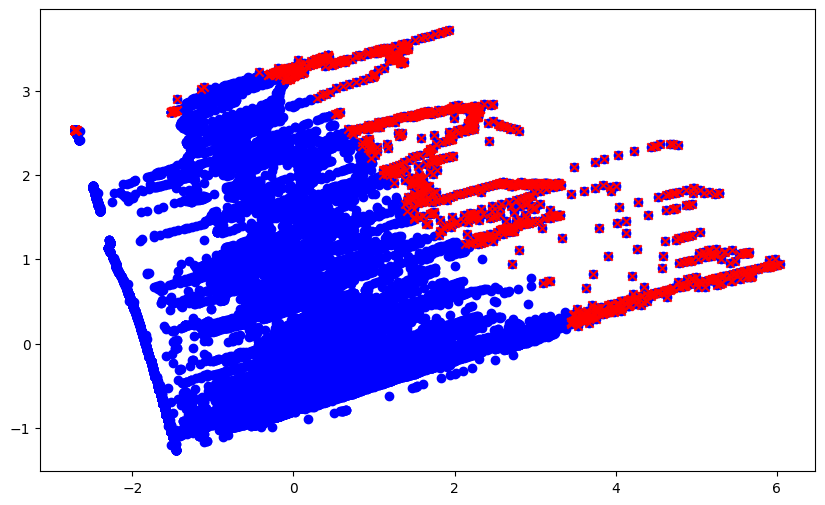

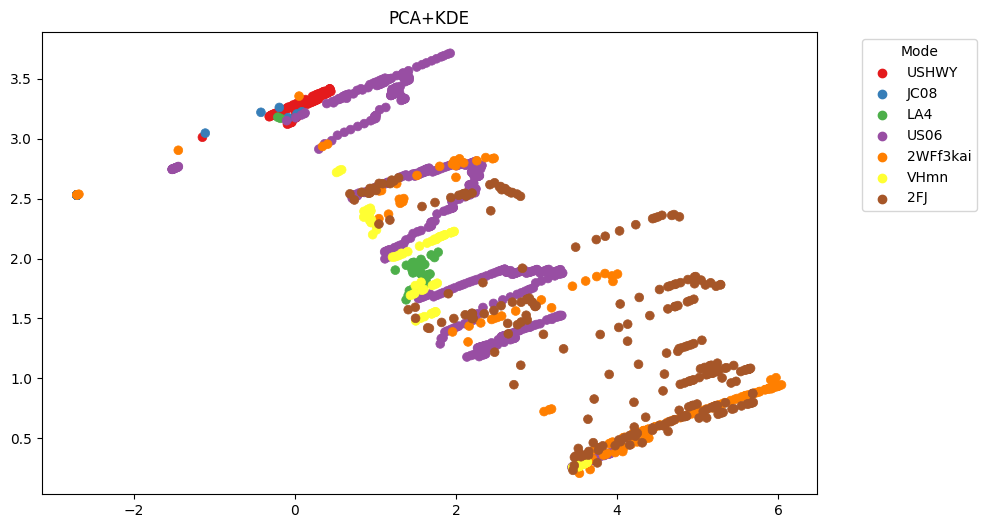

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


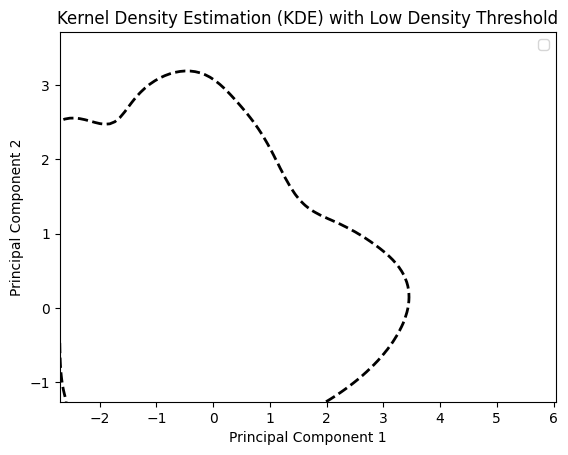

In [17]:
# KDEで密度を計算
kde = KernelDensity(bandwidth=0.5)
kde.fit(pca_train_data)
density_train = np.exp(kde.score_samples(pca_train_data))


# 低密度の閾値を設定（例：5%パーセンタイル）
low_density_threshold = np.percentile(density_train, 3)

# 低密度領域のデータを特定
is_low_density_train = density_train < low_density_threshold

# 密度分布のヒストグラムをプロット
plt.figure(figsize=(10, 6))
plt.hist(density_train, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=low_density_threshold, color='red', linestyle='--', label=f'Threshold ({low_density_threshold:.2f})')
plt.title("Density Distribution Using KDE")
plt.legend()
plt.show()

# 2D空間での低密度領域をプロット
plt.figure(figsize=(10, 6))
plt.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
plt.scatter(pca_train_data[is_low_density_train, 0], pca_train_data[is_low_density_train, 1], c='red', marker='x', label='Low Density Area')


# Visualize low-density areas in UMAP projection
filtered_modes = train_df['Mode'][is_low_density_train]  # Filter the 'Mode' labels based on low-density points

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_train_data[is_low_density_train, 0], 
                y=pca_train_data[is_low_density_train, 1], 
                hue=filtered_modes, 
                palette='Set1', 
                s=40, 
                edgecolor=None)
plt.title("PCA+KDE")
plt.legend(title='Mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# 閾値以下の領域を描画
X, Y = np.meshgrid(np.linspace(min(pca_train_data[:, 0]), max(pca_train_data[:, 0]), 100),
                   np.linspace(min(pca_train_data[:, 1]), max(pca_train_data[:, 1]), 100))
xy_sample = np.array([X.ravel(), Y.ravel()]).T
Z = np.exp(kde.score_samples(xy_sample)).reshape(X.shape)
plt.contour(X, Y, Z, levels=[low_density_threshold], colors='k', linestyles='--', linewidths=2)
plt.title(f'Kernel Density Estimation (KDE) with Low Density Threshold')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

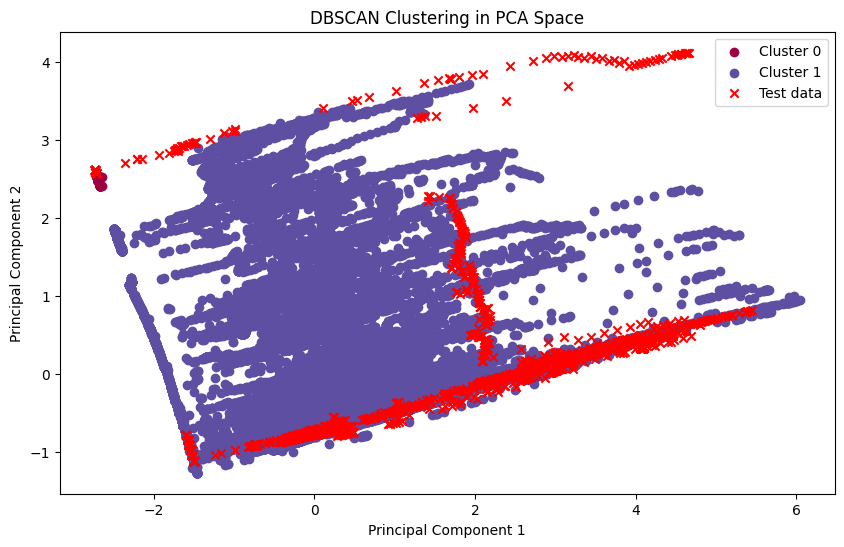

In [5]:
from sklearn.cluster import DBSCAN

# DBSCANの適用
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(pca_train_data)

# クラスタリング結果とノイズ（外挿データ）を可視化
plt.figure(figsize=(10, 6))

# クラスタリング結果のプロット
unique_labels = np.unique(dbscan_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # 黒はノイズ（外挿データ）用
        col = [0, 0, 0, 1]
    class_member_mask = (dbscan_labels == k)
    plt.scatter(pca_train_data[class_member_mask, 0], pca_train_data[class_member_mask, 1], c=[col], marker='o', label=f'Cluster {k}')

# テストデータのプロット
plt.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data')

plt.title('DBSCAN Clustering in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()
